<a href="https://colab.research.google.com/github/NyxLumen/Encephlo/blob/main/encephlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tensorflow numpy opencv-python


In [9]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Install the Kaggle API
!pip install kaggle

# Create a directory for Kaggle configuration and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set the permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.60GB/s]


In [10]:
!unzip brain-tumor-mri-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/dataset/Training/glioma/Tr-gl_0726.jpg  
  in

In [11]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

dataset_path = '/content/dataset/Training'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

img_size=224
data=[]
labels = []

#loading and preprocessing the image
def load_data():
  for category in categories:
    folder_path = os.path.join(dataset_path, category)
    label = categories.index(category)
    for img_name in os.listdir(folder_path):
      try:
        img_arr = cv2.imread(os.path.join(folder_path, img_name))

        if img_arr is None: # Check if image loaded successfully
            print(f"Warning: Could not load image {os.path.join(folder_path, img_name)}")
            continue

        # grayscale
        gray_img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to create a binary image for contour detection
        # Using Otsu's thresholding which often works well for medical images
        _, thresholded_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # get the bounding box (assuming the largest contour is the region of interest)
        contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours: # If no contours are found, skip this image
            print(f"Warning: No contours found for image {img_name}")
            continue

        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the image
        cropped_img = gray_img[y:y+h, x:x+w]

        # resize the cropped image
        resized_img = cv2.resize(cropped_img, (img_size, img_size))

        data.append(resized_img)
        labels.append(label)
      except Exception as e:
        print(f"Error processing image {img_name}: {e}")

#loading of the data
load_data()

data = np.array(data).astype('float32') / 255.0  # Normalize pixel values
labels = np.array(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the shape of the datasets
print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')

Training data shape: (4569, 224, 224)
Validation data shape: (1143, 224, 224)
Training labels shape: (4569,)
Validation labels shape: (1143,)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

#loading ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# layers on model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add Dropout after GlobalAveragePooling
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout after Dense layer
predictions = Dense(len(categories), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

img_size = 224 # Define img_size to ensure it's available

# Create an instance of ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Rotate images by up to 20 degrees
    zoom_range=0.2,             # Zoom images by up to 20%
    width_shift_range=0.2,      # Shift images horizontally by up to 20%
    height_shift_range=0.2,     # Shift images vertically by up to 20%
    shear_range=0.2,            # Shear images by up to 20 degrees
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest',        # Fill newly created pixels with the nearest value
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/Training',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='sparse',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    '/content/dataset/Training',
    target_size=(img_size, img_size),
    batch_size=16,
    class_mode='sparse',
    subset='validation'
)
#callback
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

try:
    history = model.fit(
        train_generator,
        epochs=50,  # You can adjust the number of epochs as needed
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping]
    )

    # Print final training and validation accuracy
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
except NameError as e:
    if "name 'model' is not defined" in str(e):
        print("Error: The 'model' has not been defined. Please ensure the cell where the model is built (cell vyjr5u05bbyt) is executed before this one.")
    else:
        raise e

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 196s 935ms/step - accuracy: 0.7011 - loss: 1.0015 - val_accuracy: 0.2340 - val_loss: 1.8367
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 627ms/step - accuracy: 0.8566 - loss: 0.4585 - val_accuracy: 0.2796 - val_loss: 19060.5391
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 674ms/step - accuracy: 0.8646 - loss: 0.3970 - val_accuracy: 0.2796 - val_loss: 1.3955
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 620ms/step - accuracy: 0.8920 - loss: 0.3765 - val_accuracy: 0.2287 - val_loss: 1.5420
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 620ms/step - accuracy: 0.9023 - loss: 0.2896 - val_accuracy: 0.2577 - val_loss: 12.2784
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - accuracy: 0.9155 - loss: 0.2320 - val_accuracy: 0.5074 - val_loss: 2.0102
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - accuracy: 0.9188 - loss: 0.2331 - val_accuracy: 0.4075 - val_loss: 2.4504
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 673ms/step - accuracy: 0.9321 - l

In [18]:
#Evaluation of Model
# Paths to your test dataset folders
test_dataset_path = '/content/dataset/Testing'

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

Found 1311 images belonging to 4 classes.
 1/82 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.6250 - loss: 1.1669

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8486 - loss: 0.4417
Test Accuracy: 0.906941294670105
Test Loss: 0.30299311876296997


In [19]:
model.save('brain_tumor.h5')

In [20]:
model.save('brain_tumor.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


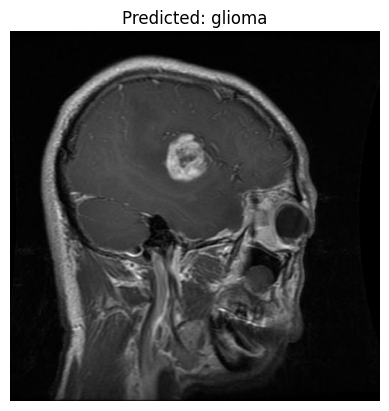

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


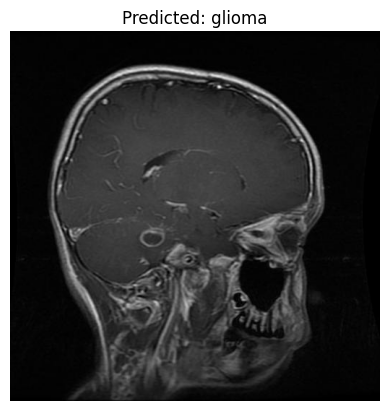

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


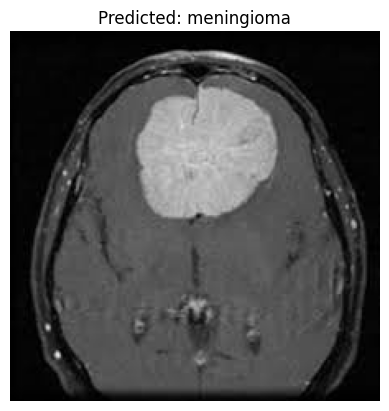

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


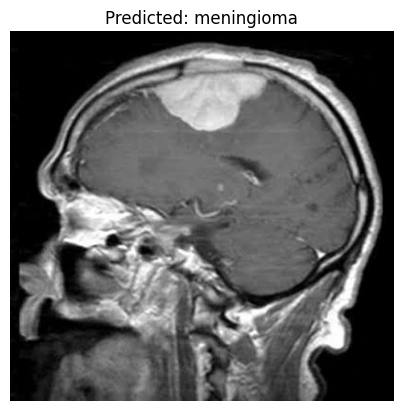

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


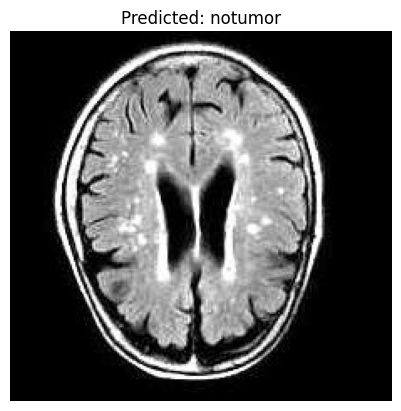

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


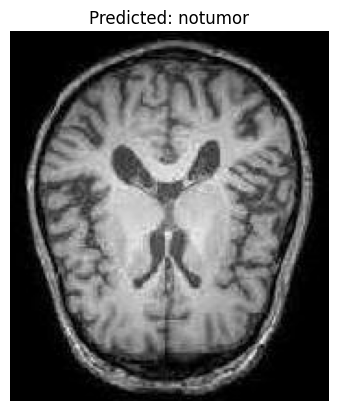

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


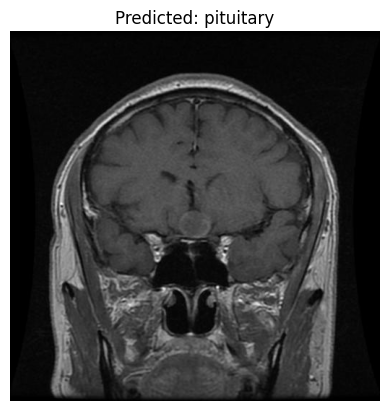

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


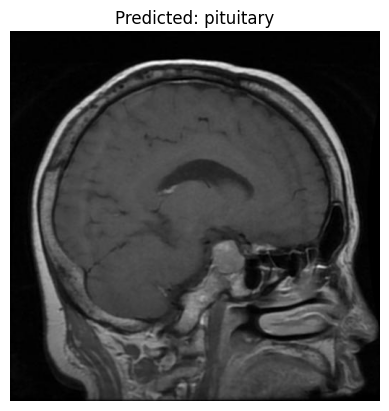

Image: /content/dataset/Testing/glioma/Te-gl_0150.jpg - Predicted Label: glioma
Image: /content/dataset/Testing/glioma/Te-gl_0212.jpg - Predicted Label: glioma
Image: /content/dataset/Testing/meningioma/Te-me_0095.jpg - Predicted Label: meningioma
Image: /content/dataset/Testing/meningioma/Te-me_0055.jpg - Predicted Label: meningioma
Image: /content/dataset/Testing/notumor/Te-no_0278.jpg - Predicted Label: notumor
Image: /content/dataset/Testing/notumor/Te-no_0161.jpg - Predicted Label: notumor
Image: /content/dataset/Testing/pituitary/Te-pi_0283.jpg - Predicted Label: pituitary
Image: /content/dataset/Testing/pituitary/Te-pi_0258.jpg - Predicted Label: pituitary


In [23]:
import matplotlib.pyplot as plt
import random

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 pixels
    img = img.astype('float32') / 255.0  # Normalize pixel values
    return img

# Mapping of category indices to labels
category_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Function to load, preprocess, and predict on test images
def predict_on_test_images(num_samples=2):
    test_images_path = '/content/dataset/Testing'
    predictions = []

    for category in categories:
        path = os.path.join(test_images_path, category)
        images = random.sample(os.listdir(path), num_samples)  # Randomly select num_samples images

        for img_name in images:
            img_path = os.path.join(path, img_name)
            img = load_and_preprocess_image(img_path)
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Make prediction
            pred = model.predict(img)
            predicted_class = np.argmax(pred)

            # Append the results
            predictions.append((img_path, category_labels[predicted_class]))

            # Display the image with prediction
            plt.imshow(cv2.imread(img_path))
            plt.title(f"Predicted: {category_labels[predicted_class]}")
            plt.axis('off')
            plt.show()

    return predictions

# Run the prediction function
predictions = predict_on_test_images()
# Print the predictions
for img_path, pred_label in predictions:
    print(f"Image: {img_path} - Predicted Label: {pred_label}")